# Prepare data for input

In [21]:
import numpy as np
import pandas as pd
import tensorflow as tf
import edward as ed
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
ed.set_seed(12227)

In [3]:
dat = pd.read_csv('data/prepared_data.csv')
print(dat.shape)
dat.head()

(687276, 7)


,stim,unit,isfirst,isrewarded,count,trial,time
0,0,1068,0,0,4,57277,0
1,0,1069,0,0,1,57277,0
2,0,1070,0,0,6,57277,0
3,0,1071,0,0,0,57277,0
4,0,1072,1,0,3,60250,0


Columns are:
- stim: original stimulus number
- unit: recorded neuron number
- isfirst, isrewarded: potential regressors of interest
- count: spike count during stimulus display period
- trial: original trial number
- time: unique stimulus code in trimmed dataset (very rare stims removed)

We need to do a couple of things to prep the data:
- turn unit codes into a 1-based unit index
- turn time into a 1-based stim index

In [4]:
# subset data for testing
dat = dat.query("unit < 1050 & time < 300")
dat.shape

(27038, 7)

In [5]:
_, unit = np.unique(dat.unit, return_inverse=True)
_, stim = np.unique(dat.time, return_inverse=True)

print(np.min(unit), np.max(unit), len(np.unique(unit)))

print(np.min(stim), np.max(stim), len(np.unique(stim)))

0 48 49
0 283 284


In [6]:
count = dat['count'].values
Xdat = dat[['isfirst', 'isrewarded']].values
Xdat.shape

(27038, 2)

# Define the model

## Constants

In [7]:
# define some needed constants
N = dat.shape[0]  # number of trials
NB = 10  # number of trials in minibatch
NU = len(np.unique(unit))  # number of units
NS = len(np.unique(stim))  # number of stims
P = Xdat.shape[1]  # number of specified regressors
K = 5  # number of latents

## Inputs and data

In [8]:
X = tf.constant(Xdat.astype('float32'))
U = tf.constant(unit)
S = tf.constant(stim)
counts = tf.constant(count)
allinds = tf.constant(np.arange(N))

Make a node that produces `NB` indices from the range $[0, N - 1]$. These are the subset of data points we want to use.

In [9]:
batch_inds, batch_counts = tf.train.batch(tf.train.slice_input_producer([allinds, counts]), NB, 
                                          name='batches')

## Generative (p) model

In [10]:
with tf.variable_scope("pmodel"):
    A = ed.models.Normal(mu=tf.zeros(NU), sigma=tf.ones(NU), name='A')
    B = ed.models.Normal(mu=tf.zeros((NU, P)), sigma=tf.ones((NU, P)), name='B')
    C = ed.models.Normal(mu=tf.zeros((NU, K)), sigma=tf.ones((NU, K)), name='C')  
    
    delta = ed.models.Beta(a=3 * tf.ones(K), b=tf.ones(K), name='delta')
    tf.scalar_summary('mean_delta', tf.reduce_mean(delta))
    log_delta = tf.log(delta)
    tf.scalar_summary('min_log_delta', tf.reduce_min(log_delta))
    tf.scalar_summary('mean_log_delta', tf.reduce_mean(log_delta))

    pi = tf.exp(tf.cumsum(log_delta), name='pi')
    tf.scalar_summary('min_pi', tf.reduce_min(pi))

    Z = ed.models.Bernoulli(p=tf.tile(tf.expand_dims(pi, 0), [NS, 1]), name='Z')
    tf.scalar_summary('mean_Z', tf.reduce_mean(tf.to_float(Z)))

    sig = ed.models.Normal(mu=[-0.1], sigma=[0.1], name='sig')

    lam_vars = (tf.gather(A, U) + tf.reduce_sum(tf.gather(B, U) * X, 1) + 
           tf.reduce_sum(tf.gather(C, U) * tf.gather(tf.to_float(Z), S), 1))
    lam = ed.models.Normal(mu=tf.gather(lam_vars, batch_inds), 
                           sigma=tf.exp(sig), name='lam')
    tf.scalar_summary('mean_lam', tf.reduce_mean(lam))


    cnt = ed.models.Poisson(lam=tf.nn.softplus(lam), value=tf.ones(NB), name='cnt')

# Recognition (q) model

In [11]:
with tf.variable_scope("qmodel"):
    q_A = ed.models.NormalWithSoftplusSigma(mu=tf.Variable(tf.random_normal((NU,))), 
                                            sigma=tf.Variable(tf.random_uniform((NU,))),
                                            name='A')
    q_B = ed.models.NormalWithSoftplusSigma(mu=tf.Variable(tf.random_normal((NU, P))), 
                                            sigma=tf.Variable(tf.random_uniform((NU, P))),
                                            name='B')
    q_C = ed.models.NormalWithSoftplusSigma(mu=tf.Variable(tf.random_normal((NU, K))), 
                                            sigma=tf.Variable(tf.random_uniform((NU, K))),
                                            name='C')
    q_Z = ed.models.BernoulliWithSigmoidP(p=tf.Variable(tf.random_normal((NS, K))), name='Z')
    tf.scalar_summary('mean_q_Z', tf.reduce_mean(tf.to_float(Z)))

    q_delta = ed.models.BetaWithSoftplusAB(a=tf.Variable(1 + tf.random_uniform((K,))),
                                           b=tf.Variable(1 + tf.random_uniform((K,))),
                                           name='delta')
    tf.scalar_summary('mean_q_delta', tf.reduce_mean(q_delta))

    lam_mu = tf.Variable(tf.random_normal((N,)))
    lam_sig = tf.Variable(tf.random_uniform((N,)))
    q_lam = ed.models.NormalWithSoftplusSigma(mu=tf.gather(lam_mu, batch_inds),
                                              sigma=tf.gather(lam_sig, batch_inds),
                                              name='lam')
    tf.scalar_summary('mean_q_lam', tf.reduce_mean(q_lam))

    q_sig = ed.models.NormalWithSoftplusSigma(mu=tf.Variable(-0.1 * tf.random_uniform((1,))),
                                              sigma=tf.Variable(tf.random_uniform((1,))),
                                              name='sig')
    tf.scalar_summary('mean_q_sig', tf.reduce_mean(q_sig))


# Do variational inference

In [12]:
data = {cnt: batch_counts}
inference = ed.KLqp({A: q_A, B: q_B, C: q_C, Z: q_Z, sig: q_sig, delta: q_delta, lam: q_lam}, 
                    data)

In [13]:
init = tf.initialize_all_variables()

# Notes before inference:

- The `logdir` keyword specifies the place to put the log file (assuming you've instrumented the code to save events, etc.). If a subdirectory is given, pointing Tensorboard at the parent directory allows you to compare across subdirectories (runs).
    - I'm using the `jmp/instrumented` branch of the `jmxpearson/edward` fork
- I had to lower the learning rate in Adam to avoid NaNs early on in learning. Gradient clipping might solve the same problem.
- I'm currently using "all" the data, but this should probably be switched to minibatches.
- I've used `n_samples` = 1, 5, 10, and 25, which all seem pretty similar after 10k iterations. 

In [14]:
inference.run(n_iter=100000, n_print=100, n_samples=1,
              logdir='data/run1',
              optimizer=tf.train.AdamOptimizer(1e-3),
              scale={lam: N/NB, cnt: N/NB})

Iteration      1 [  0%]: Loss = 32376.336
Iteration    100 [  0%]: Loss = 367329.406
Iteration    200 [  0%]: Loss = 359012.062
Iteration    300 [  0%]: Loss = 284934.562
Iteration    400 [  0%]: Loss = 403948.594
Iteration    500 [  0%]: Loss = 78713.344
Iteration    600 [  0%]: Loss = 50482.652
Iteration    700 [  0%]: Loss = 1473515.500
Iteration    800 [  0%]: Loss = 105033.516
Iteration    900 [  0%]: Loss = 872569.125
Iteration   1000 [  1%]: Loss = 52607.586
Iteration   1100 [  1%]: Loss = 4033088.250
Iteration   1200 [  1%]: Loss = 748272.000
Iteration   1300 [  1%]: Loss = 29906.422
Iteration   1400 [  1%]: Loss = 36473.871
Iteration   1500 [  1%]: Loss = 49276.605
Iteration   1600 [  1%]: Loss = 43245.121
Iteration   1700 [  1%]: Loss = 28256.328
Iteration   1800 [  1%]: Loss = 27379.195
Iteration   1900 [  1%]: Loss = 250368.062
Iteration   2000 [  2%]: Loss = 113161.391
Iteration   2100 [  2%]: Loss = 74971.477
Iteration   2200 [  2%]: Loss = 45243.535
Iteration   2300 [  2

In [15]:
q_A.value()

<tf.Tensor 'qmodel/A/sample/Reshape:0' shape=(49,) dtype=float32>

In [22]:
Zmat = q_Z.value().eval()

<IPython.core.display.Javascript object>


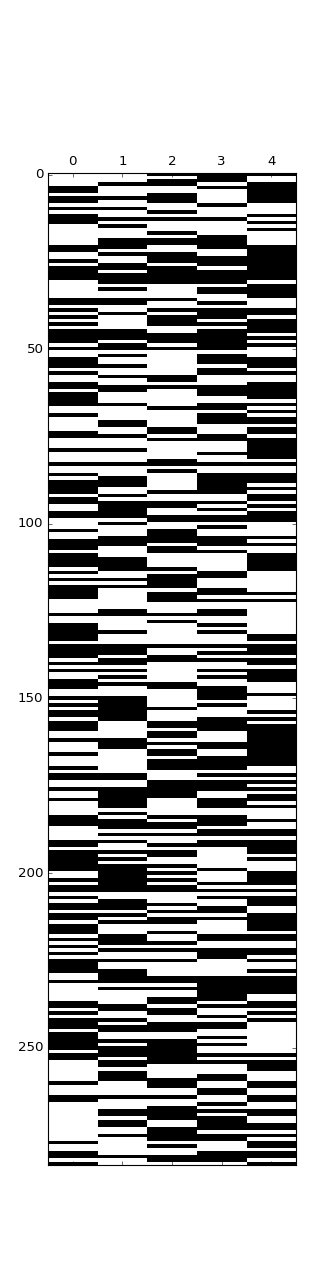

In [25]:
plt.matshow(Zmat, aspect='auto', cmap='gray')